In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import glob

In [2]:
#combining the data for each metallicity
files = sorted(glob.glob("massloss/mist_iso_*.iso"))

cols = ["EEP", "log10_isochrone_age_yr", "initial_mass", "star_mass", "star_mdot", "he_core_mass", "c_core_mass", "log_L", "log_LH", "log_LHe", "log_Teff", "log_R", "log_g", "surface_h1", "surface_he3", "surface_he4", "surface_c12", "surface_o16", "log_center_T", "log_center_Rho", "center_gamma", "center_h1", "center_he4", "center_c12", "phase"]

dfs = []

for file in files:
    #getting [Fe/H] value from the header
    feh = None
    with open(file) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if line.startswith("#") and "[Fe/H]" in line:
                value_line = lines[i+1].lstrip("#").split()
                feh = float(value_line[2])
                break
   #reading the table 
    df = pd.read_csv(file, sep=r'\s+', comment="#", header=None, names=cols)
    df["FeH"] = feh
    dfs.append(df)

all_iso = pd.concat(dfs, ignore_index=True)

In [4]:
print(all_iso.head())
print(all_iso.columns)

   EEP  log10_isochrone_age_yr  initial_mass  star_mass     star_mdot  \
0   14                     5.0      0.100000   0.100000 -9.297134e-14   
1   15                     5.0      0.102645   0.102645 -9.975347e-14   
2   16                     5.0      0.107039   0.107039 -1.104573e-13   
3   17                     5.0      0.111419   0.111419 -1.204011e-13   
4   18                     5.0      0.115789   0.115789 -1.295945e-13   

   he_core_mass  c_core_mass     log_L    log_LH  log_LHe  ...  surface_c12  \
0           0.0          0.0 -0.793667 -3.548059    -99.0  ...     0.001404   
1           0.0          0.0 -0.775254 -3.521999    -99.0  ...     0.001404   
2           0.0          0.0 -0.744810 -3.478003    -99.0  ...     0.001404   
3           0.0          0.0 -0.714749 -3.432448    -99.0  ...     0.001404   
4           0.0          0.0 -0.684996 -3.385713    -99.0  ...     0.001404   

   surface_o16  log_center_T  log_center_Rho  center_gamma  center_h1  \
0     0.00343

In [5]:
#sorting to latest age for each FeH, initial mass
all_iso_sorted = all_iso.sort_values(["FeH", "initial_mass", "log10_isochrone_age_yr"])

#making it have 1 row per FeH, initial mass
endpoints = (all_iso_sorted
             .groupby(["FeH", "initial_mass"], as_index=False)
             .tail(1))

#relevant column from this table is the "star_mass"
#that tells us what the final mass after winds is based on initial mass and [Fe/H]
print(endpoints.head())
print(endpoints.tail())

        EEP  log10_isochrone_age_yr  initial_mass  star_mass     star_mdot  \
719790  260                   10.30      0.100000   0.099998 -7.269395e-17   
625102   75                    6.15      0.100055   0.100055 -2.038251e-14   
646058  148                    7.80      0.100068   0.100068 -3.023989e-16   
715422  253                   10.15      0.100094   0.100093 -7.234343e-17   
643389  139                    7.60      0.100122   0.100122 -5.169203e-16   

        he_core_mass  c_core_mass     log_L     log_LH    log_LHe  ...  \
719790           0.0          0.0 -2.785630  -2.785428 -74.542905  ...   
625102           0.0          0.0 -1.129985 -10.109520 -99.000000  ...   
646058           0.0          0.0 -2.354749  -3.969664 -82.729063  ...   
715422           0.0          0.0 -2.788160  -2.787956 -74.635845  ...   
643389           0.0          0.0 -2.190090  -4.512318 -86.950565  ...   

        surface_c12  surface_o16  log_center_T  log_center_Rho  center_gamma  \
719790

In [20]:
def get_effective_mass(df, FeH, initial_mass):
    """
    Interpolate final mass from previous dataframe 
    (source: MESA Isochrones and Stellar Tracks)
    """

    #extracting unique sorted grids
    FeH_vals = np.sort(df['FeH'].unique())
    mass_at_FeH = []

    for FeH_i in FeH_vals:
        sub = df[df['FeH'] == FeH_i].copy()
        #dealing with potential duplicate values
        sub = sub.groupby('initial_mass', as_index=False)['star_mass'].mean()
        sub = sub.sort_values('initial_mass')
        masses = sub['initial_mass'].values
        finals = sub['star_mass'].values
        #what to do if there's not enough points to interpolate
        if len(masses) < 2:
            mass_at_FeH.append(np.nan)
            continue
        #1d interpolation in initial mass for this FeH_i
        if initial_mass < masses.min() or initial_mass > masses.max():
            mass_at_FeH.append(np.nan)
        else:
            mass_at_FeH.append(np.interp(initial_mass, masses, finals))

    FeH_vals = np.array(FeH_vals)
    mass_at_FeH = np.array(mass_at_FeH)

    #remove NaNs
    mask = ~np.isnan(mass_at_FeH)
    FeH_vals = FeH_vals[mask]
    mass_at_FeH = mass_at_FeH[mask]

    #interpolating to target FeH
    if len(FeH_vals) < 2:
        return np.nan
    if FeH < FeH_vals.min() or FeH > FeH_vals.max():
        return np.nan

    return float(np.interp(FeH, FeH_vals, mass_at_FeH))

In [17]:
#testing to see if the function works (sobsobsob)
final_m = get_effective_mass(endpoints, FeH = -0.25, initial_mass=6)
print(final_m)

5.996746099589656


## Visualizations

**1: Heatmap**

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

(presentation of MIST data - doesn't interpolate between points)

C:\Users\nandi\AppData\Local\Temp\ipykernel_40332\1556354565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endpoints["loss_frac"] = 1 - endpoints["star_mass"] / endpoints["initial_mass"]


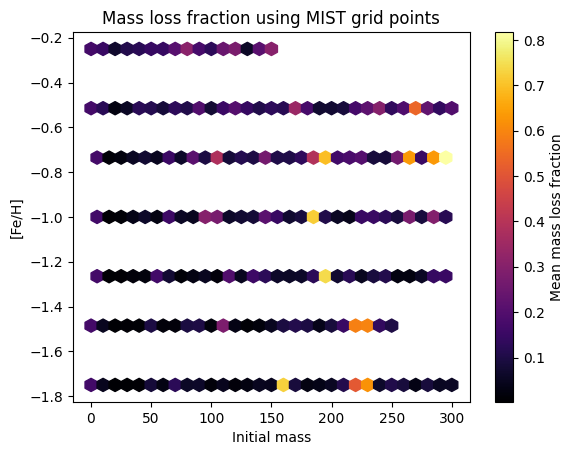

In [27]:
#this is a one-time graph, the same one will show up for every user input
endpoints["loss_frac"] = 1 - endpoints["star_mass"] / endpoints["initial_mass"]
plt.hexbin(endpoints["initial_mass"], endpoints["FeH"], C=endpoints["loss_frac"], gridsize=30, reduce_C_function=np.mean, cmap="inferno")
plt.colorbar(label="Mean mass loss fraction")
plt.xlabel("Initial mass")
plt.ylabel("[Fe/H]")
plt.title("Mass loss fraction using MIST grid points")
plt.show()

**2: Graph of mass loss over time (created for each new user input)**

In [39]:
def plot_massloss_evol(df, initial_mass, FeH):
    """
    Plot star_mass vs log10_isochrone_age_yr for given initial_mass and FeH.
    Finds the closest matching track from the all_iso Dataframe and plots that.
    """
    #finding closest track
    closest_feh = df.loc[(df['FeH'] - FeH).abs().idxmin(), 'FeH']
    track = df[(np.abs(df['initial_mass'] - initial_mass) < 0.1) & (df['FeH'] == closest_feh)].sort_values('log10_isochrone_age_yr')

    if len(track) == 0:
        print("No matching track found :(")
        return

    ages_yr = 10**track['log10_isochrone_age_yr'] #converting log age to years
    plt.plot(ages_yr / 1e9, track['star_mass'], 'b-', linewidth=2)
    plt.xlabel('Age (Gyr)')
    plt.ylabel('Stellar Mass ($M_\\odot$)')
    plt.title(f"Mass Loss Track: M_init-{initial_mass} Msun, [Fe/H]={FeH}")
    plt.grid(True, alpha=0.3)
    plt.yscale('log') #using log scale because stars live long lives
    plt.show()

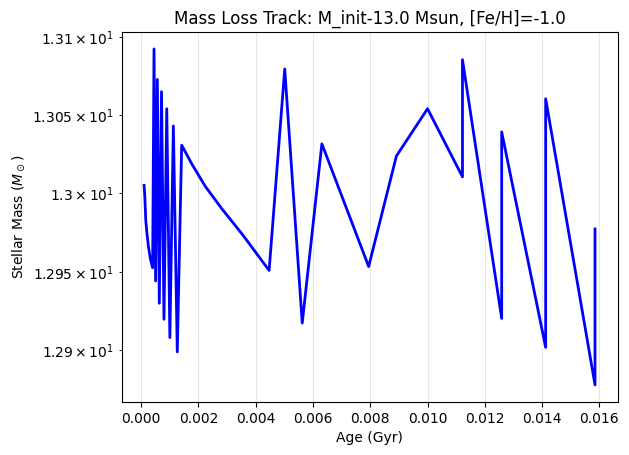

In [40]:
#testing
plot_massloss_evol(all_iso, initial_mass=13.0, FeH=-1.0)